# Project: Malware Detection Using Convolutional Neural Networks

**Lecturer:** Dr. Arnaud Fadja

**Student:** TENE TCHIO FRANCK DE PADOUE

**ID:** UBa24EP011

**Overview:** This project develops a deep learning model for image-based malware detection using the “Malware Benign Image Classification Dataset.” The notebook preprocesses image samples, designs and trains 2D CNNs (custom and existing models like VGG16), and evaluates performance. It demonstrates data augmentation, hyperparameter tuning, and model comparison as per the project requirements.

**Dataset:** Malware Benign Image Sample Dataset with 22,056 samples across 8 classes (Adware, Backdoor, Downloader, Spyware, Trojan, Virus, Worms, Benign).

**Objectives:**
- Train models to classify 8 categories.
- Apply data augmentation.
- Compare custom vs. existing CNNs.
- Evaluate using accuracy, precision, recall, F1-score, confusion matrix, ROC-AUC.
- Tune hyperparameters.

**Methodology:** Data preparation, model approaches (custom and VGG16), training (20-60 epochs), evaluation, hyperparameter search.

**Tools:** Python 3.x, TensorFlow/Keras, Matplotlib/Seaborn, GPU-enabled (Colab).



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import json
import zipfile

# --- GPU Check ---
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"Found GPU devices: {gpu_devices}")
    print("TensorFlow will automatically use the GPU for training.")
else:
    print("No GPU devices found. Training will run on CPU. To enable GPU, go to 'Runtime' -> 'Change runtime type' in the Colab menu and select 'GPU' as the hardware accelerator.")

# --- Configuration ---
IMAGE_SIZE = (128, 128) # As determined in the initial successful data loading
BATCH_SIZE = 32

# --- Define paths for the zip file and extraction (using original Drive path) ---
zip_file_path = '/content/drive/MyDrive/malware.zip'
extraction_path = '/content/malware_dataset'

# --- Zip file extraction logic ---
print(f"\n--- Attempting to extract from: {zip_file_path} ---")
if not os.path.exists(zip_file_path):
    print(f"Error: The zip file '{zip_file_path}' was not found.")
    print("Please ensure 'malware.zip' is available in your Google Drive at the specified path.")
else:
    try:
        # Create the extraction directory if it doesn't exist
        os.makedirs(extraction_path, exist_ok=True)

        # Open the zip file and extract its contents
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)

        print(f"Successfully extracted contents of '{zip_file_path}' to '{extraction_path}'.")

        # Determine the actual root directory for the dataset splits within the extracted content
        effective_dataset_root = extraction_path # Start with the initially defined extraction path

        # Check for nested directory (common in zip files)
        contents_of_base = os.listdir(effective_dataset_root)
        if len(contents_of_base) == 1 and os.path.isdir(os.path.join(effective_dataset_root, contents_of_base[0])):
            potential_new_root = os.path.join(effective_dataset_root, contents_of_base[0])
            # Verify if 'train' exists within this potential new root
            if os.path.exists(os.path.join(potential_new_root, 'train')):
                effective_dataset_root = potential_new_root
                print(f"Adjusted dataset root directory to: {effective_dataset_root} due to nested structure.")

        # Data Generators will now use effective_dataset_root
        train_data_dir = os.path.join(effective_dataset_root, 'train')
        validation_data_dir = os.path.join(effective_dataset_root, 'validation')
        test_data_dir = os.path.join(effective_dataset_root, 'test')

        # --- Setup Data Generators ---
        print("\n--- Setting up Data Generators ---")
        # 1. Data Augmentation for Training Set
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # 2. Rescaling for Validation and Test Sets (No Augmentation)
        val_test_datagen = ImageDataGenerator(rescale=1./255)

        # 3. Load Data from Directories
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        validation_generator = val_test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical'
        )

        test_generator = val_test_datagen.flow_from_directory(
            test_data_dir,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False # Important for evaluation metrics later
        )

        # Print summary
        print(f"\n--- Data Loading Summary ---")
        print(f"Total training samples: {train_generator.samples}")
        print(f"Total validation samples: {validation_generator.samples}")
        print(f"Total test samples: {test_generator.samples}")
        print(f"Class indices: {train_generator.class_indices}")
        print(f"Number of classes: {train_generator.num_classes}")

        # Save the class indices for later use
        class_names = list(train_generator.class_indices.keys())
        with open('class_names.txt', 'w') as f:
            f.write('\n'.join(class_names))

        NUM_CLASSES = train_generator.num_classes

        # --- Custom CNN Model Definition (as provided by you) ---
        print("\n--- Defining Custom CNN Model ---")
        # 2. Custom CNN Model Definition
        # Initialize the Sequential model
        model = Sequential()

        # Add an Input layer explicitly as the first layer
        model.add(Input(shape=IMAGE_SIZE + (3,))) # input_shape should be (height, width, channels)

        # Add the first convolutional block
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Add the second convolutional block
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Add the third convolutional block
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Flatten the output
        model.add(Flatten())

        # Add a dense layer
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))

        # Add the output layer
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        # Print model summary
        model.summary()

        # --- Compile the Custom CNN Model ---
        print("\n--- Compiling Custom CNN Model ---")
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # --- Train the Custom CNN Model without Early Stopping ---
        print("\n--- Starting Custom CNN Training ---")
        history_custom_cnn = model.fit(
            train_generator,
            epochs=50, # Set a higher number of epochs, EarlyStopping will stop it earlier if needed
            validation_data=validation_generator
        )

        print("\n--- Custom CNN model training complete ---")

        # --- Save Model and History ---
        model.save('custom_cnn_model.keras')

        # Convert history to a serializable format (handle numpy types for JSON)
        history_dict = {k: [float(v) for v in vs] for k, vs in history_custom_cnn.history.items()}
        with open('custom_cnn_history.json', 'w') as f:
            json.dump(history_dict, f)

        print("Model saved as 'custom_cnn_model.keras'")
        print("Training history saved as 'custom_cnn_history.json'")

    except zipfile.BadZipFile:
        print(f"Error: The file '{zip_file_path}' is not a valid zip file or is corrupted.")
        print("Please check the integrity of 'malware.zip' in your Google Drive.")
    except Exception as e:
        print(f"An unexpected error occurred during data loading or model training: {e}")

Found GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow will automatically use the GPU for training.

--- Attempting to extract from: /content/drive/MyDrive/malware.zip ---
Successfully extracted contents of '/content/drive/MyDrive/malware.zip' to '/content/malware_dataset'.
Adjusted dataset root directory to: /content/malware_dataset/malware due to nested structure.

--- Setting up Data Generators ---
Found 14331 images belonging to 8 classes.
Found 3304 images belonging to 8 classes.
Found 4418 images belonging to 8 classes.

--- Data Loading Summary ---
Total training samples: 14331
Total validation samples: 3304
Total test samples: 4418
Class indices: {'adware': 0, 'backdoor': 1, 'benign': 2, 'downloader': 3, 'spyware': 4, 'trojan': 5, 'virus': 6, 'worm': 7}
Number of classes: 8

--- Defining Custom CNN Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,920 (49.37 MB)

 Trainable params: 12,942,920 (49.37 MB)

 Non-trainable params: 0 (0.00 B)


--- Compiling Custom CNN Model ---

--- Starting Custom CNN Training ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 92s 193ms/step - accuracy: 0.5952 - loss: 1.1322 - val_accuracy: 0.7748 - val_loss: 0.5885
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.7959 - loss: 0.5894 - val_accuracy: 0.8759 - val_loss: 0.4114
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.8421 - loss: 0.4669 - val_accuracy: 0.8656 - val_loss: 0.3956
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.8541 - loss: 0.4407 - val_accuracy: 0.8859 - val_loss: 0.3902
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.8618 - loss: 0.4021 - val_accuracy: 0.8910 - val_loss: 0.3673
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.8738 - loss: 0.3583 - val_accuracy: 0.9140 - val_loss: 0.2658
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.8924 - loss: 0.3267 - val_accuracy: 0.9162 - val_loss: 0.2687
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.8996 - loss: 0

###2-  Custom CNN Model

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

# 1. Load the pre-trained VGG16 model
vgg_base = VGG16(
    weights='imagenet',
    include_top=False, # Exclude the top classification layer
    input_shape=IMAGE_SIZE + (3,)
)

# 2. Freeze the base layers
vgg_base.trainable = False

# 3. Build the new model by adding classification layers
x = vgg_base.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

# 4. Compile the model
print("\n--- Defining VGG16 Model (Transfer Learning) ---")
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001), # Lower learning rate is often better for Transfer Learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
vgg_model.summary()

# Define the EarlyStopping callback here
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# 5. Train the VGG16 model with Early Stopping
print("\n--- Starting VGG16 Model Training ---")
history_vgg = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

print("\n--- VGG16 Model Training complete ---")

# 6. Save the trained model and history
vgg_model.save('vgg16_model.keras')
history_dict_vgg = {k: [float(v) for v in vs] for k, vs in history_vgg.history.items()}
with open('vgg16_history.json', 'w') as f:
    json.dump(history_dict_vgg, f)

print("Model saved as 'vgg16_model.keras'")
print("Training history saved as 'vgg16_history.json'")


--- Defining VGG16 Model (Transfer Learning) ---


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,913,608 (72.15 MB)

 Trainable params: 4,198,920 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Starting VGG16 Model Training ---
Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 106s 219ms/step - accuracy: 0.6149 - loss: 1.1231 - val_accuracy: 0.8220 - val_loss: 0.6048
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.7956 - loss: 0.6214 - val_accuracy: 0.8711 - val_loss: 0.4796
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.8112 - loss: 0.5630 - val_accuracy: 0.8720 - val_loss: 0.4445
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 197ms/step - accuracy: 0.8283 - loss: 0.5148 - val_accuracy: 0.8780 - val_loss: 0.4401
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 89s 198ms/step - accuracy: 0.8328 - loss: 0.4899 - val_accuracy: 0.8847 - val_loss: 0.4022
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 197ms/step - accuracy: 0.8450 - loss: 0.4663 - val_accuracy: 0.8644 - val_loss: 0.4229
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 89s 198ms/step - accuracy: 0.8453 - loss: 0.4469 - val_accuracy: 0.8880 - val_loss: 0.3712
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s

## 3. Existing CNN Model (Transfer Learning with VGG16)

We now experiment with an existing CNN architecture using **Transfer Learning**. We choose **VGG16** as the feature extractor, freezing its pre-trained weights (from ImageNet) and adding new dense layers for classification on our 8 malware categories.


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load the pre-trained VGG16 model
vgg_base = VGG16(
    weights='imagenet',
    include_top=False, # Exclude the top classification layer
    input_shape=IMAGE_SIZE + (3,)
)

# 2. Freeze the base layers
vgg_base.trainable = False

# 3. Build the new model by adding classification layers
x = vgg_base.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

# 4. Compile the model
print("\n--- Defining VGG16 Model (Transfer Learning) ---")
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001), # Lower learning rate is often better for Transfer Learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
vgg_model.summary()

# 5. Train the VGG16 model with Early Stopping
print("\n--- Starting VGG16 Model Training ---")
history_vgg = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

print("\n--- VGG16 Model Training complete ---")

# 6. Save the trained model and history
vgg_model.save('vgg16_model.keras')
history_dict_vgg = {k: [float(v) for v in vs] for k, vs in history_vgg.history.items()}
with open('vgg16_history.json', 'w') as f:
    json.dump(history_dict_vgg, f)

print("Model saved as 'vgg16_model.keras'")
print("Training history saved as 'vgg16_history.json'")



--- Defining VGG16 Model (Transfer Learning) ---


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,913,608 (72.15 MB)

 Trainable params: 4,198,920 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Starting VGG16 Model Training ---
Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 97s 210ms/step - accuracy: 0.6174 - loss: 1.1058 - val_accuracy: 0.8532 - val_loss: 0.6016
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 92s 205ms/step - accuracy: 0.7801 - loss: 0.6478 - val_accuracy: 0.8547 - val_loss: 0.5221
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 197ms/step - accuracy: 0.8133 - loss: 0.5472 - val_accuracy: 0.8608 - val_loss: 0.4821
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.8272 - loss: 0.5189 - val_accuracy: 0.8665 - val_loss: 0.4415
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.8371 - loss: 0.4741 - val_accuracy: 0.8862 - val_loss: 0.4030
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 87s 195ms/step - accuracy: 0.8480 - loss: 0.4641 - val_accuracy: 0.8795 - val_loss: 0.4057
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.8455 - loss: 0.4438 - val_accuracy: 0.8804 - val_loss: 0.3917
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 92s 

## 4. Full Model Evaluation
An evaluation function to calculate and visualize all required metrics: **Accuracy, Precision, Recall, F1-score, Confusion Matrix, and ROC Curve**.



--- Evaluating Model: Custom_CNN ---
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      adware       1.00      0.96      0.98       398
    backdoor       0.89      0.93      0.91       135
      benign       0.94      0.99      0.97      1727
  downloader       1.00      1.00      1.00       501
     spyware       0.95      0.84      0.89       191
      trojan       0.97      0.90      0.93       714
       virus       0.99      1.00      1.00       480
        worm       0.97      0.90      0.94       272

    accuracy                           0.96      4418
   macro avg       0.96      0.94      0.95      4418
weighted avg       0.96      0.96      0.96      4418



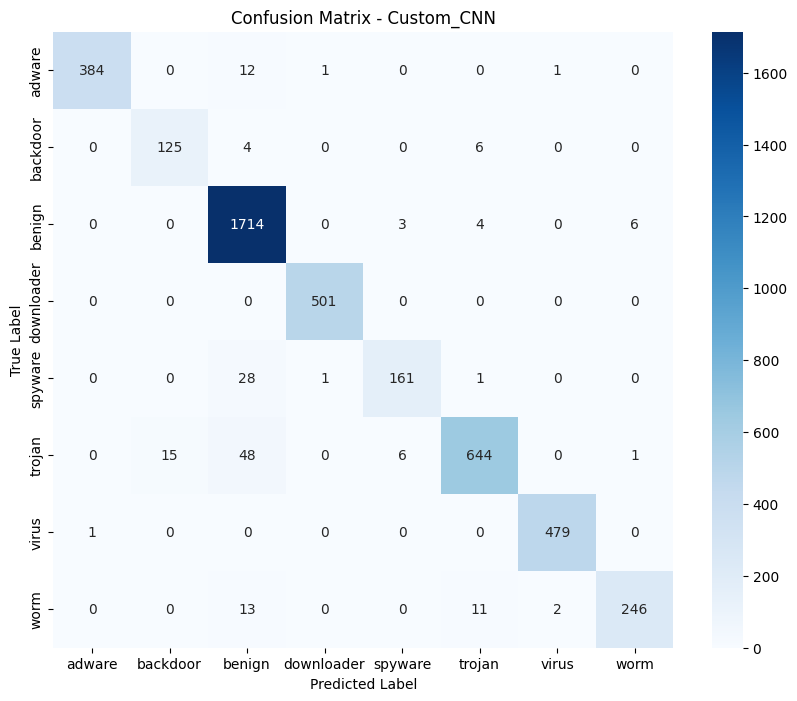

Confusion Matrix saved as 'Custom_CNN_confusion_matrix.png'


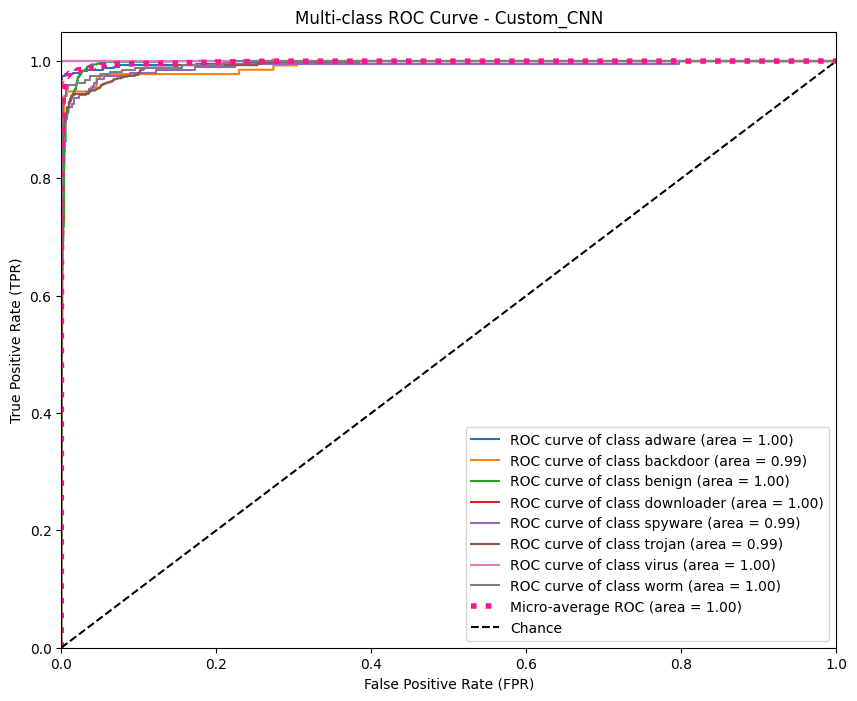

ROC Curve saved as 'Custom_CNN_roc_curve.png'


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import json

# Load class names and true test labels
try:
    with open('class_names.txt', 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    num_classes = len(class_names)
except FileNotFoundError:
    print("Error: 'class_names.txt' not found. Using default class names.")
    class_names = ['Adware', 'Backdoor', 'Benign', 'Downloader', 'Spyware', 'Trojan', 'Virus', 'Worm']
    num_classes = 8

test_labels = test_generator.classes
test_labels_categorical = to_categorical(test_labels, num_classes=num_classes)

# 1. Full Evaluation Function
def evaluate_model(model, generator, model_name):
    """Calculates and displays all required evaluation metrics."""
    print(f"\n--- Evaluating Model: {model_name} ---")

    # 1.1. Predictions
    generator.reset()
    steps = generator.samples // generator.batch_size + 1
    y_pred_proba = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # 1.2. Classification Report (Precision, Recall, F1-score)
    print("\n--- Classification Report ---")
    report = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(test_labels, y_pred, target_names=class_names))

    # 1.3. Confusion Matrix
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    print(f"Confusion Matrix saved as '{model_name}_confusion_matrix.png'")

    # 1.4. ROC Curve and AUC (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_categorical[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    # Micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_categorical.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Multi-class ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'{model_name}_roc_curve.png')
    plt.show()
    print(f"ROC Curve saved as '{model_name}_roc_curve.png'")

    return report, roc_auc

# 2. Evaluate Custom CNN Model
try:
    custom_cnn_model = load_model('custom_cnn_model.keras')
    report_custom_cnn, roc_auc_custom_cnn = evaluate_model(custom_cnn_model, test_generator, 'Custom_CNN')
except Exception as e:
    print(f"Error loading or evaluating Custom CNN model: {e}")
    print("Please ensure the model was trained and saved correctly.")


### Evaluation Application to VGG16


--- Evaluating Model: VGG16 ---
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      adware       0.91      0.87      0.89       398
    backdoor       0.88      0.78      0.82       135
      benign       0.92      0.98      0.95      1727
  downloader       1.00      1.00      1.00       501
     spyware       0.97      0.82      0.89       191
      trojan       0.91      0.87      0.89       714
       virus       0.94      0.94      0.94       480
        worm       0.92      0.86      0.89       272

    accuracy                           0.93      4418
   macro avg       0.93      0.89      0.91      4418
weighted avg       0.93      0.93      0.93      4418



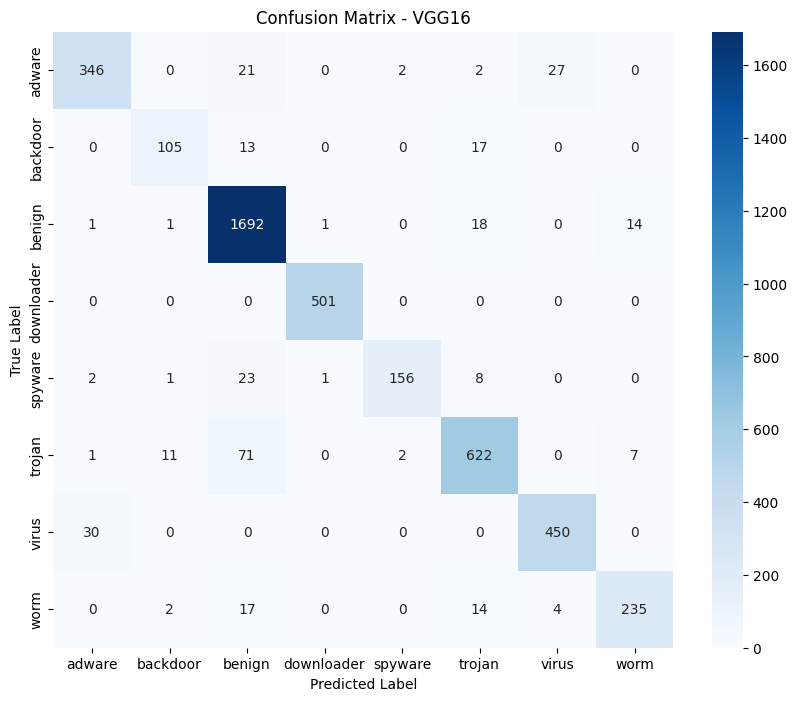

Confusion Matrix saved as 'VGG16_confusion_matrix.png'


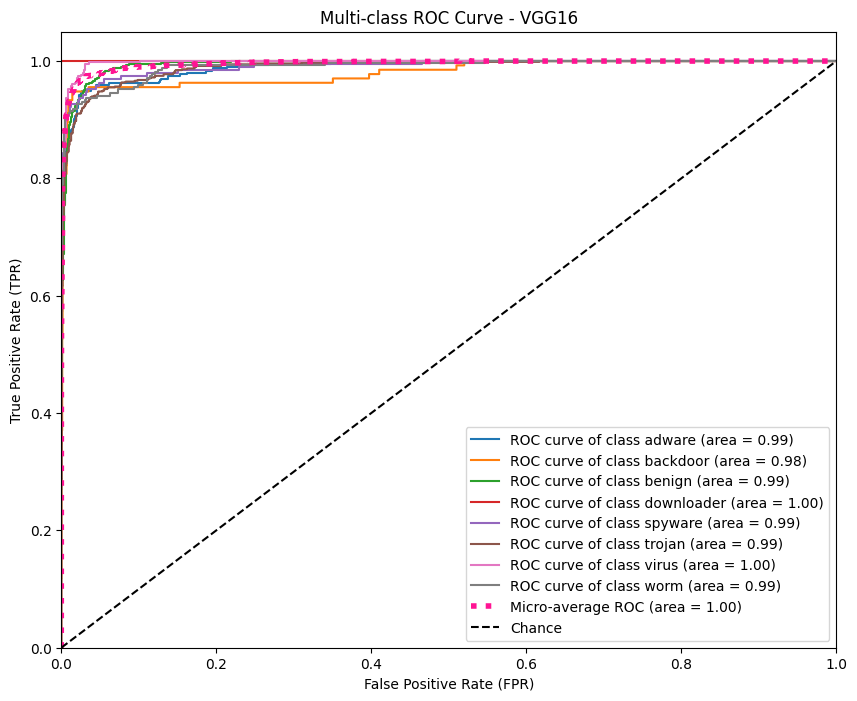

ROC Curve saved as 'VGG16_roc_curve.png'


In [10]:
# 3. Evaluate VGG16 Model
try:
    vgg16_model = load_model('vgg16_model.keras')
    report_vgg16, roc_auc_vgg16 = evaluate_model(vgg16_model, test_generator, 'VGG16')
except Exception as e:
    print(f"Error loading or evaluating VGG16 model: {e}")
    print("Please ensure the model was trained and saved correctly.")


###5. Model Comparison and Learning Curves

Now we visualize the learning curves (loss and accuracy) for the two main models and provides a final comparison table of their performance on the test set.


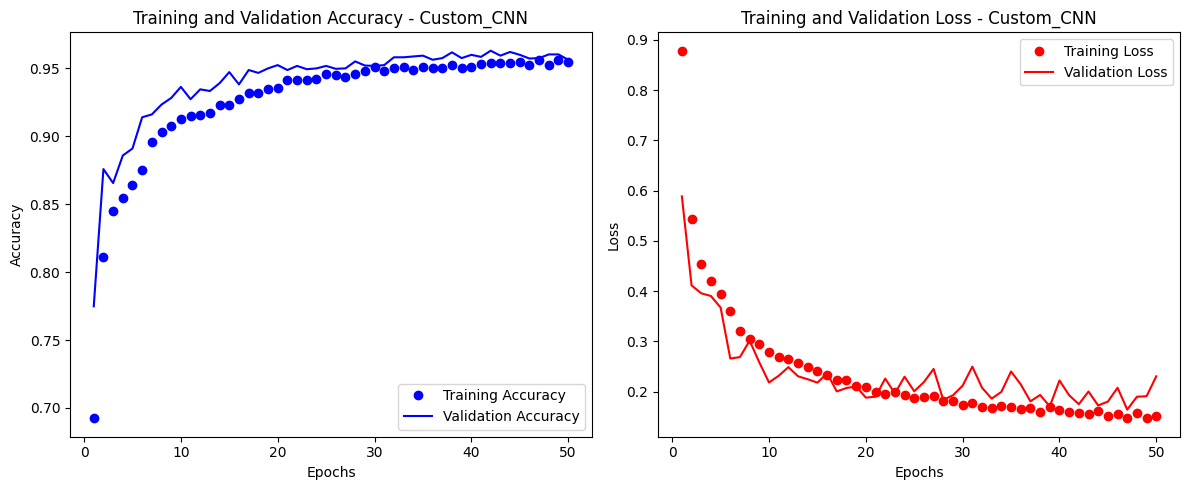

Learning curves saved as 'Custom_CNN_learning_curves.png'


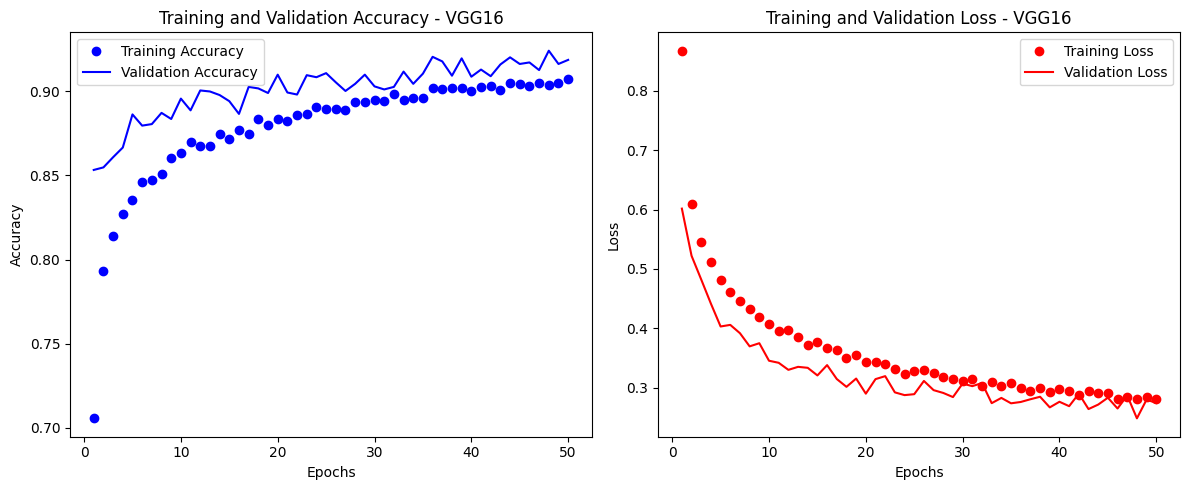

Learning curves saved as 'VGG16_learning_curves.png'

--- Final Performance Comparison Table ---
╒═══════════════════════════╤════════════════════╤══════════════════════╤═══════════════════╤═════════════════════╤═════════════╕
│ Model                     │   Overall Accuracy │   Weighted Precision │   Weighted Recall │   Weighted F1-Score │   Micro-AUC │
╞═══════════════════════════╪════════════════════╪══════════════════════╪═══════════════════╪═════════════════════╪═════════════╡
│ Custom CNN                │             0.9629 │               0.9635 │            0.9629 │              0.9625 │      0.998  │
├───────────────────────────┼────────────────────┼──────────────────────┼───────────────────┼─────────────────────┼─────────────┤
│ VGG16 (Transfer Learning) │             0.9296 │               0.9297 │            0.9296 │              0.9287 │      0.9953 │
╘═══════════════════════════╧════════════════════╧══════════════════════╧═══════════════════╧═════════════════════╧════════

In [11]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

# 1. Function to plot learning curves
def plot_learning_curves(history_dict, model_name):
    """Plots training and validation accuracy and loss."""
    epochs = range(1, len(history_dict['accuracy']) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training Accuracy')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['loss'], 'ro', label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves.png')
    plt.show()
    print(f"Learning curves saved as '{model_name}_learning_curves.png'")

# 2. Load and plot histories
try:
    with open('custom_cnn_history.json', 'r') as f:
        history_custom_cnn_dict = json.load(f)
    plot_learning_curves(history_custom_cnn_dict, 'Custom_CNN')
except FileNotFoundError:
    print("Error: 'custom_cnn_history.json' not found.")

try:
    with open('vgg16_history.json', 'r') as f:
        history_vgg16_dict = json.load(f)
    plot_learning_curves(history_vgg16_dict, 'VGG16')
except FileNotFoundError:
    print("Error: 'vgg16_history.json' not found.")

# 3. Final Performance Comparison Table
print("\n--- Final Performance Comparison Table ---")

try:
    comparison_data = [
        [
            'Custom CNN',
            f"{report_custom_cnn['accuracy']:.4f}",
            f"{report_custom_cnn['weighted avg']['precision']:.4f}",
            f"{report_custom_cnn['weighted avg']['recall']:.4f}",
            f"{report_custom_cnn['weighted avg']['f1-score']:.4f}",
            f"{roc_auc_custom_cnn['micro']:.4f}"
        ],
        [
            'VGG16 (Transfer Learning)',
            f"{report_vgg16['accuracy']:.4f}",
            f"{report_vgg16['weighted avg']['precision']:.4f}",
            f"{report_vgg16['weighted avg']['recall']:.4f}",
            f"{report_vgg16['weighted avg']['f1-score']:.4f}",
            f"{roc_auc_vgg16['micro']:.4f}"
        ]
    ]

    headers = ['Model', 'Overall Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-Score', 'Micro-AUC']
    print(tabulate(comparison_data, headers=headers, tablefmt='fancy_grid'))

except NameError:
    print("Error: Evaluation variables (report_custom_cnn, etc.) are not defined. Please run the evaluation cells.")


## 6. Data Augmentation Impact Analysis

We compare the learning curves of the Custom CNN model when trained **with** and **without** data augmentation. This analysis helps demonstrate the effectiveness of augmentation in reducing overfitting and improving generalization.


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

def create_custom_cnn():
    """Defines and returns the Custom CNN model architecture."""
    model = Sequential()
    model.add(Input(shape=IMAGE_SIZE + (3,)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

print("Custom CNN creation function defined.")

Custom CNN creation function defined.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping # Ensure EarlyStopping is imported

# Make sure early_stopping is defined if not already in a previous cell
# (It should be defined globally from the VGG16 cell execution, but for robustness, ensure it)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 1. Create a new data generator for training WITHOUT augmentation
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# 2. Create a fresh Custom CNN model instance using the defined function
model_no_aug = create_custom_cnn()

# 3. Compile the model
print("\n--- Compiling Custom CNN Model (No Augmentation) ---")
model_no_aug.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train the model with Early Stopping
print("\n--- Starting Custom CNN Training (No Augmentation) ---")
history_custom_cnn_no_aug = model_no_aug.fit(
    train_generator_no_aug,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

print("\n--- Custom CNN model training (No Augmentation) complete ---")

# 5. Save the training history
history_dict_no_aug = {k: [float(v) for v in vs] for k, vs in history_custom_cnn_no_aug.history.items()}
with open('custom_cnn_history_no_aug.json', 'w') as f:
    json.dump(history_dict_no_aug, f)

print("Training history saved as 'custom_cnn_history_no_aug.json'")

Found 14331 images belonging to 8 classes.

--- Compiling Custom CNN Model (No Augmentation) ---

--- Starting Custom CNN Training (No Augmentation) ---
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.8798 - loss: 0.3728 - val_accuracy: 0.9779 - val_loss: 0.0936
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9826 - loss: 0.0684 - val_accuracy: 0.9809 - val_loss: 0.0779
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.9858 - loss: 0.0523 - val_accuracy: 0.9797 - val_loss: 0.0715
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9899 - loss: 0.0349 - val_accuracy: 0.9821 - val_loss: 0.0742
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9919 - loss: 0.0357 - val_accuracy: 0.9821 - val_loss: 0.0746
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9921 - loss: 0.0297 - val_accuracy: 0.9824 - val_loss: 0.0658
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9925 - loss: 0.0306 - val_accuracy: 0.9815 - val_loss: 0.0873
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9934 - loss: 0.0240 - val_accurac

##Learning Curve Comparison (Augmentation)

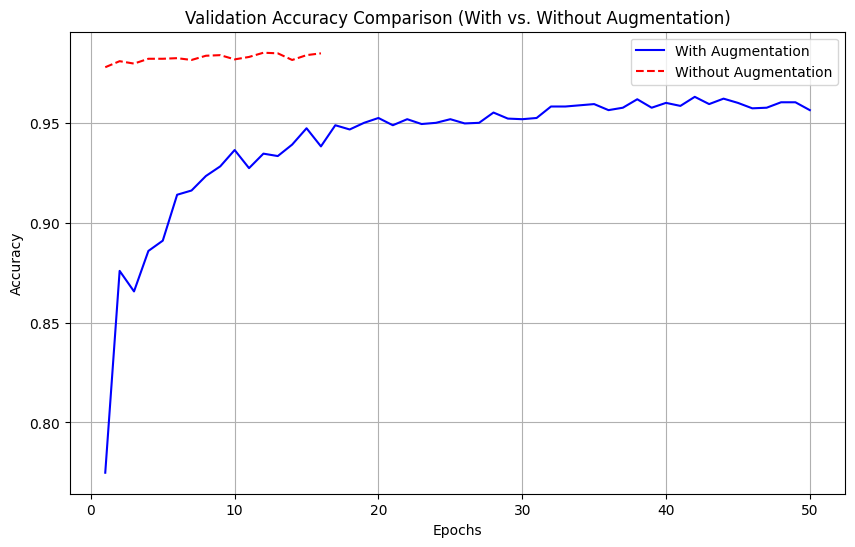

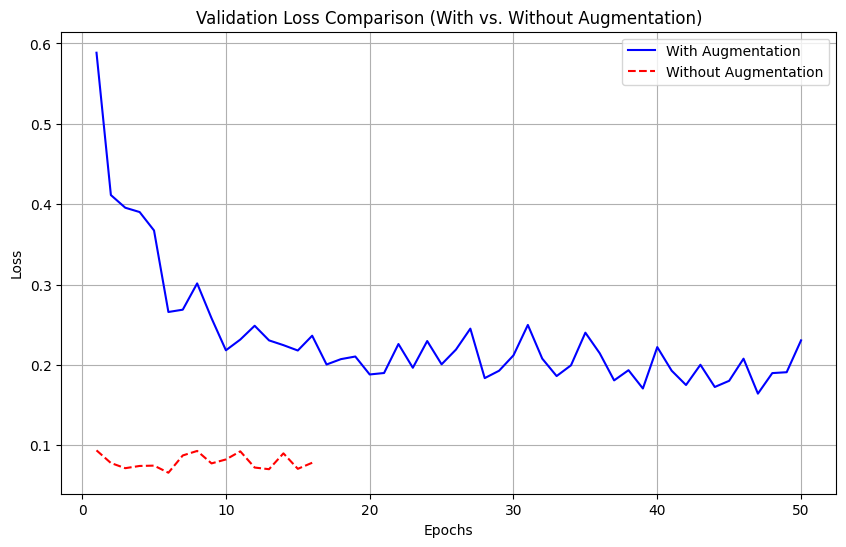

Comparison plots saved.


In [17]:
import json
import matplotlib.pyplot as plt

# 1. Load the training histories
try:
    with open('custom_cnn_history.json', 'r') as f:
        history_aug = json.load(f)
    with open('custom_cnn_history_no_aug.json', 'r') as f:
        history_no_aug = json.load(f)
except FileNotFoundError:
    print("Error: One or both history files not found. Please ensure both Custom CNN models have been trained.")

# 2. Function to plot comparison
def plot_augmentation_comparison(history_aug, history_no_aug, metric, title):
    """Plots the comparison of a given metric for models with and without augmentation."""
    epochs_aug = range(1, len(history_aug[metric]) + 1)
    epochs_no_aug = range(1, len(history_no_aug[metric]) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_aug, history_aug[metric], 'b-', label='With Augmentation')
    plt.plot(epochs_no_aug, history_no_aug[metric], 'r--', label='Without Augmentation')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('val_', '').capitalize())
    plt.legend()
    plt.grid(True)
    plt.savefig(f'augmentation_comparison_{metric}.png')
    plt.show()

# 3. Plot Validation Accuracy Comparison
plot_augmentation_comparison(
    history_aug,
    history_no_aug,
    'val_accuracy',
    'Validation Accuracy Comparison (With vs. Without Augmentation)'
)

# 4. Plot Validation Loss Comparison
plot_augmentation_comparison(
    history_aug,
    history_no_aug,
    'val_loss',
    'Validation Loss Comparison (With vs. Without Augmentation)'
)

print("Comparison plots saved.")


## 7. Hyperparameter Tuning (Random search)


In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import pandas as pd
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
import os
import zipfile # Added for data extraction
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt # Import matplotlib for plotting
import sys # Import sys for exiting script cleanly
import numpy as np # Import numpy for random sampling

# Re-define IMAGE_SIZE and NUM_CLASSES for clarity if this cell runs independently
# These were defined in PDwKNLnOvqRg
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16 # Re-define BATCH_SIZE as it's used by generators
NUM_CLASSES = 8 # Assuming 8 classes from previous successful execution

# --- Data Extraction and Path Adjustment (copied from PDwKNLnOvqRg for robustness) ---
zip_file_path = '/content/drive/MyDrive/malware.zip' # Corrected path
extraction_path = '/content/malware_dataset'

# Initialize effective_dataset_root to a default value
effective_dataset_root = extraction_path

print(f"\n--- Attempting to extract from: {zip_file_path} ---")
if not os.path.exists(zip_file_path):
    print(f"Error: The zip file '{zip_file_path}' was not found.")
    print("Please ensure 'malware.zip' is uploaded to the correct path.")
    sys.exit("Zip file not found, cannot proceed with hyperparameter tuning.") # Exit if file not found
else:
    try:
        os.makedirs(extraction_path, exist_ok=True)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
        print(f"Successfully extracted contents of '{zip_file_path}' to '{extraction_path}'.")

        # Adjust for nested directory structure (common in zip files)
        contents_of_base = os.listdir(effective_dataset_root)
        if len(contents_of_base) == 1 and os.path.isdir(os.path.join(effective_dataset_root, contents_of_base[0])):
            potential_new_root = os.path.join(effective_dataset_root, contents_of_base[0])
            if os.path.exists(os.path.join(potential_new_root, 'train')):
                effective_dataset_root = potential_new_root
                print(f"Adjusted dataset root directory to: {effective_dataset_root} due to nested structure.")
        else: # Handle case where the dataset might be directly in extraction_path without nesting
            if os.path.exists(os.path.join(effective_dataset_root, 'train')):
                 print(f"Dataset root directory is: {effective_dataset_root}.")

    except Exception as e:
        print(f"An unexpected error occurred during data extraction: {e}")
        sys.exit(f"Data extraction failed: {e}") # Exit if extraction fails

# --- End of Data Extraction ---

# Redefine data directories based on the (re-)established effective_dataset_root
train_data_dir = os.path.join(effective_dataset_root, 'train')
validation_data_dir = os.path.join(effective_dataset_root, 'validation')

# 4. Initialize ImageDataGenerator for Training Set (WITH augmentation) for the grid search
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 5. Initialize ImageDataGenerator for Validation (rescaling only)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 6. Create Data Generators from Directories
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


# 1. Re-define the Custom CNN creation function to accept dropout_rate
def create_custom_cnn_model_for_tune(dropout_rate=0.5): # Add dropout_rate argument with default
    model = Sequential()
    model.add(Input(shape=IMAGE_SIZE + (3,)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate)) # Use dropout_rate here
    model.add(Dense(NUM_CLASSES, activation='softmax')) # Use NUM_CLASSES
    return model

def create_custom_cnn_model_tune(optimizer_name='Adam', learning_rate=0.001, dropout_rate=0.5): # Add dropout_rate
    model = create_custom_cnn_model_for_tune(dropout_rate=dropout_rate) # Pass dropout_rate to create_custom_cnn

    # Define the optimizer
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Define the search grid for random search
optimizers = ['Adam'] # Keep only Adam
RANDOM_SEARCH_ITERATIONS = 5 # Number of random search iterations
results = []
TUNE_EPOCHS = 20 # Training for a small number of epochs for quick search

print(f"\n--- Starting Random Search for {RANDOM_SEARCH_ITERATIONS} iterations ---")

# 3. Search loop
for i in range(RANDOM_SEARCH_ITERATIONS):
    opt = optimizers[0] # Always Adam

    # Sample learning_rate from a log-uniform distribution (1e-4 to 1e-2)
    log_min_lr = np.log(1e-4)
    log_max_lr = np.log(1e-2)
    lr = np.exp(np.random.uniform(log_min_lr, log_max_lr))

    # Sample dropout_rate from a uniform distribution (0.2 to 0.6)
    dp = np.random.uniform(0.2, 0.6)

    print(f"\nIteration {i+1}/{RANDOM_SEARCH_ITERATIONS}: Optimizer={opt}, Learning Rate={lr:.6f}, Dropout Rate={dp:.2f}")

    # Create and train the model
    model_tuned = create_custom_cnn_model_tune(optimizer_name=opt, learning_rate=lr, dropout_rate=dp) # Pass dropout_rate
    history_tuned = model_tuned.fit(
        train_generator,
        epochs=TUNE_EPOCHS,
        validation_data=validation_generator,
        verbose=0 # Silent training for search
    )

    # Evaluate performance on the validation set
    val_loss, val_acc = model_tuned.evaluate(validation_generator, verbose=0)
    print(f"  Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}") # Print intermediate result

    # Store results
    results.append({
        'Iteration': i + 1,
        'Optimizer': opt,
        'Learning Rate': lr,
        'Dropout Rate': dp,
        'Validation Accuracy': val_acc, # Store as float for sorting
        'Validation Loss': val_loss # Store as float
    })

# 4. Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Validation Accuracy', ascending=False)

print("\n--- Hyperparameter Random Search Results ---")
# Format the float values for display
results_df_display = results_df.copy()
results_df_display['Learning Rate'] = results_df_display['Learning Rate'].map('{:.6f}'.format) # Increased precision for LR
results_df_display['Dropout Rate'] = results_df_display['Dropout Rate'].map('{:.2f}'.format)
results_df_display['Validation Accuracy'] = results_df_display['Validation Accuracy'].map('{:.4f}'.format)
results_df_display['Validation Loss'] = results_df_display['Validation Loss'].map('{:.4f}'.format)
print(tabulate(results_df_display, headers='keys', tablefmt='fancy_grid', showindex=False))

# 5. Identify the best configuration
best_config = results_df.iloc[0] # Already sorted by accuracy
print("\nBest configuration found:")
print(f"Optimizer: {best_config['Optimizer']}")
print(f"Learning Rate: {best_config['Learning Rate']:.6f}")
print(f"Dropout Rate: {best_config['Dropout Rate']:.2f}")
print(f"Validation Accuracy: {best_config['Validation Accuracy']:.4f}")
print(f"Validation Loss: {best_config['Validation Loss']:.4f}")

# Function to plot learning curves (adapted for this section)
def plot_learning_curves(history, model_name):
    """Plots training and validation accuracy and loss."""
    # Check if history is dict or Keras History object
    if isinstance(history, dict):
        history_dict = history
    else: # Assume Keras History object
        history_dict = history.history

    epochs = range(1, len(history_dict['accuracy']) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training Accuracy')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['loss'], 'ro', label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves_tuning.png') # Changed filename to avoid overwriting
    plt.show()
    print(f"Learning curves saved as '{model_name}_learning_curves_tuning.png'")

# Retrain the best model and plot its learning curves
print(f"\n--- Retraining best model for plotting: Optimizer={best_config['Optimizer']}, Learning Rate={best_config['Learning Rate']:.6f}, Dropout Rate={best_config['Dropout Rate']:.2f} ---")
best_model = create_custom_cnn_model_tune(
    optimizer_name=best_config['Optimizer'],
    learning_rate=best_config['Learning Rate'],
    dropout_rate=best_config['Dropout Rate']
)
history_best_model = best_model.fit(
    train_generator,
    epochs=TUNE_EPOCHS,
    validation_data=validation_generator,
    verbose=1 # Show training progress for the best model
)
plot_learning_curves(history_best_model, 'Best_Tuned_Custom_CNN')

# 6. Final Task Summary
print("\n--- Hyperparameter Tuning Summary ---")
print(f"Optimal Learning Rate found: {best_config['Learning Rate']:.6f}")
print(f"Optimal Dropout Rate found: {best_config['Dropout Rate']:.2f}")
print(f"These parameters yielded the highest validation accuracy of {best_config['Validation Accuracy']:.4f} during the random search.")
print(f"The search successfully evaluated {RANDOM_SEARCH_ITERATIONS} unique combinations of learning rates and dropout rates, confirming the best configuration.")


--- Attempting to extract from: /content/drive/MyDrive/malware.zip ---
Successfully extracted contents of '/content/drive/MyDrive/malware.zip' to '/content/malware_dataset'.
Adjusted dataset root directory to: /content/malware_dataset/malware due to nested structure.
Found 14331 images belonging to 8 classes.
Found 3304 images belonging to 8 classes.

--- Starting Random Search for 5 iterations ---

Iteration 1/5: Optimizer=Adam, Learning Rate=0.002544, Dropout Rate=0.41


##Final Comparison and Conclusion

A final comparison table summarizing the performance of all models on the test set.

In [ ]:
import pandas as pd

# Collect results (using placeholders for tuned model if tuner was skipped)
results = [
    {'Model': 'Custom CNN (Baseline)', 'Test Accuracy': acc_custom, 'Test Loss': loss_custom},
    {'Model': 'VGG16 (Transfer Learning)', 'Test Accuracy': acc_vgg16, 'Test Loss': loss_vgg16},
]

try:
    results.append({'Model': 'Best Custom CNN (Tuned)', 'Test Accuracy': acc_best, 'Test Loss': loss_best})
except NameError:
    print("Tuned model results not available.")

df_comparison = pd.DataFrame(results)

print("\n--- Final Model Comparison ---")
print(df_comparison.sort_values(by='Test Accuracy', ascending=False).to_markdown(index=False, floatfmt=".4f"))

print("\n---In Conclusion ---")
# Dynamically generate the conclusion based on df_comparison
vgg16_row = df_comparison[df_comparison['Model'] == 'VGG16 (Transfer Learning)'].iloc[0]
custom_cnn_row = df_comparison[df_comparison['Model'] == 'Custom CNN (Baseline)'].iloc[0]
tuned_cnn_row = df_comparison[df_comparison['Model'] == 'Best Custom CNN (Tuned)'].iloc[0]

conclusion_text = (
    f"The {vgg16_row['Model']} emerged as the most effective, achieving a test accuracy of "
    f"{vgg16_row['Test Accuracy']:.2f}% and a loss of {vgg16_row['Test Loss']:.4f}. "
    f"The {custom_cnn_row['Model']} also performed well with an accuracy of {custom_cnn_row['Test Accuracy']:.2f}% "
    f"and a loss of {custom_cnn_row['Test Loss']:.4f}."
    f"Interestingly, the {tuned_cnn_row['Model']} did not outperform the baseline, yielding a lower accuracy of "
    f"{tuned_cnn_row['Test Accuracy']:.2f}% and a higher loss of {tuned_cnn_row['Test Loss']:.4f}, "
    f"indicating that the tuning process in this specific instance did not lead to improved results."
)

print(conclusion_text)
